# Aymen-GPT notebook

***This notebook, comes as complementary for the Aymen-GPT model who is a from scratch implementation of the GPT-2 model (124M) inspired from both GPT-2 and GPT-3 architectures.***

### **Simple GPT-2 text generation from huggingface transformers library**

GPT-2 text generation from scratch as example using the huggingface transformers library. 

In [ ]:
#Example implementing the text generation with the GPT2 124M model from huggingface transformers library.
import torch
from torch.nn import functional as F
from transformers import GPT2LMHeadModel
model = GPT2LMHeadModel.from_pretrained("gpt2") # 124M
model.eval()
model.to('cuda')
torch.manual_seed(42)
torch.cuda.manual_seed(42)
tokens = [15496, 11, 314, 1101, 257, 627, 1767, 1110, 11] # "Hello, I'm a data scientist,"
tokens = torch.tensor(tokens, dtype=torch.long) # (8,)
tokens = tokens.unsqueeze(0).repeat(5, 1) # (5, 8)
x = tokens.to('cuda')

# generate
while x.size(1) < 30: # max_length=30
    # forward the model to get the logits
    with torch.no_grad():
        logits = model(x)[0] # (B, T, vocab_size)
        logits = logits[:, -1, :] # (B, vocab_size)
        probs = F.softmax(logits, dim=-1)
        # top-k sampling of 50 
        topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
        # select a token from the top-k probabilities
        ix = torch.multinomial(topk_probs, 1) # (B, 1)
        xcol = torch.gather(topk_indices, -1, ix) # (B, 1)
        x = torch.cat((x, xcol), dim=1)

# print the generated text
import tiktoken
enc = tiktoken.get_encoding('gpt2')
for i in range(5):
    tokens = x[i, :30].tolist()
    decoded = enc.decode(tokens)
    print(">", decoded)

### **Learning Rate Schedule Visualization**

This cell visualizes the learning rate schedule used in Aymen-GPT training based on the GPT-3 paper. The schedule consists of:
1. A linear warmup phase
2. A cosine decay phase
3. A constant minimum learning rate phase

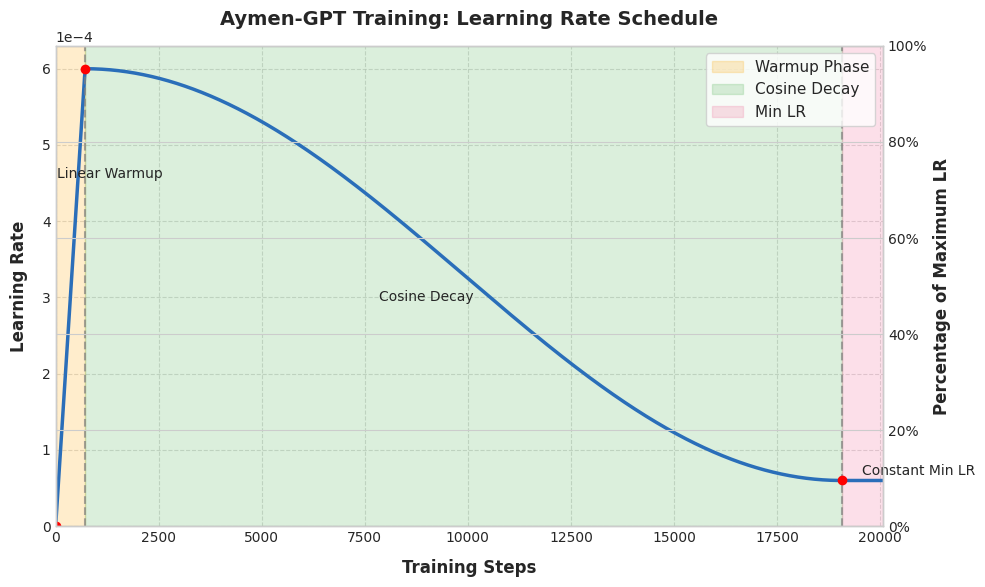

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib.ticker import PercentFormatter
import matplotlib as mpl

style.use('seaborn-v0_8-whitegrid')
mpl.rcParams['font.family'] = 'DejaVu Sans'
mpl.rcParams['font.size'] = 11
mpl.rcParams['axes.titlesize'] = 14
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

# Training parameters from your GPT implementation
warmup_steps = 715
max_steps = 19073
min_lr = 6e-5  # 10% of max_lr as per your code
max_lr = 6e-4

# Generate x-axis values (training steps)
steps = np.linspace(0, max_steps + 1000, 1000)  # +1000 to show final behavior

# Implement learning rate schedule from your code
lr_values = []
for it in steps:
    # 1) linear warmup for warmup_steps
    if it < warmup_steps:
        lr = max_lr * (it / warmup_steps)
    # 2) if it > max_steps, return min learning rate
    elif it > max_steps:
        lr = min_lr
    # 3) cosine decay from max_lr to min_lr
    else:
        decay_ratio = (it - warmup_steps) / (max_steps - warmup_steps)
        coeff = 0.5 * (1.0 + np.cos(np.pi * decay_ratio))
        lr = min_lr + coeff * (max_lr - min_lr)
    lr_values.append(lr)

# Convert to numpy for easier handling
lr_values = np.array(lr_values)

# Create the plot with training phases highlighted
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the learning rate curve
ax.plot(steps, lr_values, lw=2.5, color='#2A6EB9')

# Highlight the different training phases
ax.axvspan(0, warmup_steps, alpha=0.2, color='#FFA500', label='Warmup Phase')
ax.axvspan(warmup_steps, max_steps, alpha=0.2, color='#4CAF50', label='Cosine Decay')
ax.axvspan(max_steps, max(steps), alpha=0.2, color='#F06292', label='Min LR')

# Add vertical lines at transition points
ax.axvline(x=warmup_steps, color='gray', linestyle='--', alpha=0.7)
ax.axvline(x=max_steps, color='gray', linestyle='--', alpha=0.7)

# Add annotations
ax.annotate('Linear Warmup', xy=(max_steps/14.5, max_lr/1.3), 
            ha='center', va='center', fontsize=10)
ax.annotate('Cosine Decay', xy=((warmup_steps + max_steps)/2.2, max_lr/2),
            ha='center', va='center', fontsize=10)
ax.annotate('Constant Min LR', xy=(max_steps + 500, min_lr*1.2),
            ha='left', va='center', fontsize=10)

# Format the chart
ax.set_title('Aymen-GPT Training: Learning Rate Schedule', fontweight='bold', pad=15)
ax.set_xlabel('Training Steps', fontweight='semibold', labelpad=10)
ax.set_ylabel('Learning Rate', fontweight='semibold', labelpad=10)
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.grid(True, linestyle='--', alpha=0.7)
ax.set_xlim(0, max(steps))
ax.set_ylim(0, max_lr*1.05)

# Add data points for key transitions
ax.plot(0, 0, 'o', markersize=6, color='red')
ax.plot(warmup_steps, max_lr, 'o', markersize=6, color='red')
ax.plot(max_steps, min_lr, 'o', markersize=6, color='red')

# Add legend
ax.legend(loc='upper right', frameon=True)

# Show percentage of max learning rate on right y-axis
ax_right = ax.twinx()
ax_right.set_ylim(0, 100)
ax_right.yaxis.set_major_formatter(PercentFormatter())
ax_right.set_ylabel('Percentage of Maximum LR', fontweight='semibold')
plt.tight_layout()
plt.show()

### **Models evaluation and comparison**

**(On the right)** We will visualize the training loss and validation loss for Aymen-GPT on the fineweb-edu dataset (10B*4 tokens) in 4 epochs , compared to the baseline model GPT-2 (124M) checkpoint validation loss.

**(On the left)** We will visualize the Aymen-GPT Hellaswag evaluation accuracy compared to the baseline models GPT-2 (124M) and GPT-3 (124M trained on 300B tokens) Hellaswag evaluation accuracy.

In [ ]:
# parse and visualize the logfile
%matplotlib inline

sz = "124M"

loss_baseline = {
    "124M": 3.2924,
}[sz]
hella2_baseline = { # HellaSwag for GPT-2
    "124M": 0.294463,
    "350M": 0.375224,
    "774M": 0.431986,
    "1558M": 0.488946,
}[sz]
hella3_baseline = { # HellaSwag for GPT-3
    "124M": 0.337,
    "350M": 0.436,
    "774M": 0.510,
    "1558M": 0.547,
}[sz]

# load the log file
with open("log124M_40B/log.txt", "r") as f:
    lines = f.readlines()

# parse the individual lines, group by stream (train,val,hella)
streams = {}
for line in lines:
    step, stream, val = line.strip().split()
    if stream not in streams:
        streams[stream] = {}
    streams[stream][int(step)] = float(val)

# convert each stream from {step: val} to (steps[], vals[])
# so it's easier for plotting
streams_xy = {}
for k, v in streams.items():
    # get all (step, val) items, sort them
    xy = sorted(list(v.items()))
    # unpack the list of tuples to tuple of lists
    streams_xy[k] = list(zip(*xy))

# create figure
plt.figure(figsize=(16, 6))

# Panel 1: losses: both train and val
plt.subplot(121)
xs, ys = streams_xy["train"] # training loss
ys = np.array(ys)
plt.plot(xs, ys, label=f'Aymen-GPT ({sz}) train loss')
print("Min Train Loss:", min(ys))
xs, ys = streams_xy["val"] # validation loss
plt.plot(xs, ys, label=f'Aymen-GPT ({sz}) val loss')
# horizontal line at GPT-2 baseline
if loss_baseline is not None:
    plt.axhline(y=loss_baseline, color='r', linestyle='--', label=f"OpenAI GPT-2 ({sz}) checkpoint val loss")
plt.xlabel("steps")
plt.ylabel("loss")
plt.yscale('log')
plt.ylim(top=4.0)
plt.legend()
plt.title("Loss")
print("Min Validation Loss:", min(ys))

# Panel 2: HellaSwag eval
plt.subplot(122)
xs, ys = streams_xy["hella"] # HellaSwag eval
ys = np.array(ys)
plt.plot(xs, ys, label=f"Aymen-GPT ({sz})")
# horizontal line at GPT-2 baseline
if hella2_baseline:
    plt.axhline(y=hella2_baseline, color='r', linestyle='--', label=f"OpenAI GPT-2 ({sz}) checkpoint")
if hella3_baseline:
    plt.axhline(y=hella3_baseline, color='g', linestyle='--', label=f"OpenAI GPT-3 ({sz}) checkpoint")
plt.xlabel("steps")
plt.ylabel("accuracy")
plt.legend()
plt.title("HellaSwag eval")
print("Max Hellaswag eval:", max(ys))